### Installation and Requirements

In [1]:
# !pip install qc-grid
# !pip install qc-atomdb

### Import required libraries

In [2]:
import numpy as np
from functools import lru_cache

from grid.onedgrid import Trapezoidal
from grid.rtransform import LinearFiniteRTransform
from grid.utils import convert_cart_to_sph, generate_real_spherical_harmonics
from grid.becke import BeckeWeights
from grid import AtomGrid
from atomdb import make_promolecule

import matplotlib.pyplot as plt

In [5]:

# Calculate electron density at grid points
def calc_num_e(promol, points):
    return promol.density(points)


### Calculate density function for visulization

In [12]:
xi = 0
xf = 11

atcoords = np.array([[0, 0, 0]])
atnums = np.array([10])  # Atomic number 10 is neon
promol = make_promolecule(atnums=atnums, coords=atcoords, dataset='slater')

atnum = promol.atoms[0]._data.atnum
atcoord = promol.coords[0]


onedgrid = Trapezoidal(npoints = 1000)
radial_grid = LinearFiniteRTransform(xi, xf).transform_1d_grid(onedgrid)
# print("radial grid:", radial_grid.points.shape)
angular_grid = AtomGrid.from_preset(
    atnum=atnum,
    preset='fine',
    rgrid=radial_grid,
    center=atcoord
)

density_list = []
idx = angular_grid._indices
for i in range(len(idx)-1):
    dens = calc_num_e(promol, angular_grid.points[idx[i]:idx[i+1]])
    weights = angular_grid.weights[idx[i]:idx[i+1]]
    val = np.nansum(dens * weights)
    density_list.append(val)
    # print(val)

dens_full = calc_num_e(promol, angular_grid.points)

### Define Main Adaptive Function

In [21]:
# Global list to save the calculated points, weights, and differences
global_xc_list = []
global_wc_list = []
global_diff_list = []

def adaptive_recursive_fn(xi, xf, promol,
                        thresh=1,
                        variable='num_electrons',
                        onedgrid_fn=Trapezoidal,
                        radialgrid_fn=LinearFiniteRTransform):

    print(f"Calculating adaptive grid for [{xi}, {xf}]")
    # print("promol:", promol)

    match variable:
        case "num_electrons":
            calc_variable = calc_num_e
            tol = 1e-15


    atnum = promol.atoms[0]._data.atnum
    atcoord = promol.coords[0]


    # 2-point grid
    onedgrid_2 = onedgrid_fn(npoints = 2)
    radial_grid_2 = radialgrid_fn(xi, xf).transform_1d_grid(onedgrid_2)
    angular_grid_2 = AtomGrid.from_preset(
        atnum=atnum,
        preset='ultrafine',
        rgrid=radial_grid_2,
        center=atcoord
    )
    dens_test_2 = promol.density(angular_grid_2.points)
    val_ref_integrand_2 = calc_variable(promol, angular_grid_2.points)
    val_ref_2 = np.nansum(val_ref_integrand_2 * angular_grid_2.weights)
    # print(f"\n\t2 Points Angular Value: {val_ref_2}")


    # 3-point grid
    onedgrid_3 = onedgrid_fn(npoints = 3)
    radial_grid_3 = radialgrid_fn(xi, xf).transform_1d_grid(onedgrid_3)
    angular_grid_3 = AtomGrid.from_preset(
        atnum=atnum,
        preset='ultrafine',
        rgrid=radial_grid_3,
        center=atcoord
    )
    dens_test_3 = promol.density(angular_grid_2.points)
    val_ref_integrand_3 = calc_variable(promol, angular_grid_3.points)
    val_ref_3 = np.nansum(val_ref_integrand_3 * angular_grid_3.weights)
    # print(f"\t3 Points Angular Value: {val_ref_3}")

    # N-point grid only to see the more accurate results, not used in the algorithm. Here, N = 100
    onedgrid_N = onedgrid_fn(npoints = 100)
    radial_grid_N = radialgrid_fn(xi, xf).transform_1d_grid(onedgrid_N)
    angular_grid_N = AtomGrid.from_preset(
        atnum=atnum,
        preset='ultrafine',
        rgrid=radial_grid_N,
        center=atcoord
    )
    dens_test_N = promol.density(angular_grid_N.points)
    val_ref_integrand_N = calc_variable(promol, angular_grid_N.points)
    val_ref_N = np.nansum(val_ref_integrand_N * angular_grid_N.weights)
    # print(f"N Points Angular Value: {val_ref_N}")

    # Obtain the center point and weight to further range subdivision. Index [1] used because it's the midpoint from [0,1,2] in 3-points grid
    xc = radial_grid_3.points[1]
    wc = radial_grid_3.weights[1]

    # Calculate the difference
    diff = abs(val_ref_2 - val_ref_3)

    # Save and print the value
    global_xc_list.append(xc)
    global_wc_list.append(wc)
    global_diff_list.append(diff)
    # print(f"xc: {xc}, wc: {wc}")
    # print(f"\t2-point and 3-point grid differences: {diff:.6e}")
    # print(global_xc_list)
    # print(global_wc_list)

    if diff < thresh:
        return diff
    else:
        # Continue recursively
        return {
            "left": adaptive_recursive_fn(xi, xc, promol, thresh, variable, onedgrid_fn, radialgrid_fn),
            "right": adaptive_recursive_fn(xc, xf, promol, thresh, variable, onedgrid_fn, radialgrid_fn)
        }

### Main Execution

In [22]:
x_i = 0
x_f = 10

atcoords = np.array([[0, 0, 0]])
atnums = np.array([10])  # Atomic number 10 is neon
promol = make_promolecule(atnums=atnums, coords=atcoords, dataset='slater')


# Add initial point x_i and x_f to the global list
radial_grid_0 = LinearFiniteRTransform(x_i, x_f).transform_1d_grid(Trapezoidal(npoints=2))
global_xc_list.extend(radial_grid_0.points[:2])
global_wc_list.extend(radial_grid_0.weights[:2])

# Run the main adaptive recursive radial function
diff_log = adaptive_recursive_fn(0, 10, promol=promol, thresh=0.0001)

Calculating adaptive grid for [0, 10]
Calculating adaptive grid for [0, 5.0]
Calculating adaptive grid for [0, 2.5]
Calculating adaptive grid for [0, 1.25]
Calculating adaptive grid for [0, 0.625]
Calculating adaptive grid for [0, 0.3125]
Calculating adaptive grid for [0, 0.15625]
Calculating adaptive grid for [0, 0.078125]
Calculating adaptive grid for [0, 0.0390625]
Calculating adaptive grid for [0, 0.01953125]
Calculating adaptive grid for [0, 0.009765625]
Calculating adaptive grid for [0, 0.0048828125]
Calculating adaptive grid for [0.0048828125, 0.009765625]
Calculating adaptive grid for [0.009765625, 0.01953125]
Calculating adaptive grid for [0.009765625, 0.0146484375]
Calculating adaptive grid for [0.0146484375, 0.01953125]
Calculating adaptive grid for [0.01953125, 0.0390625]
Calculating adaptive grid for [0.0390625, 0.078125]
Calculating adaptive grid for [0.0390625, 0.05859375]
Calculating adaptive grid for [0.0390625, 0.048828125]
Calculating adaptive grid for [0.0390625, 0.

### Visualization

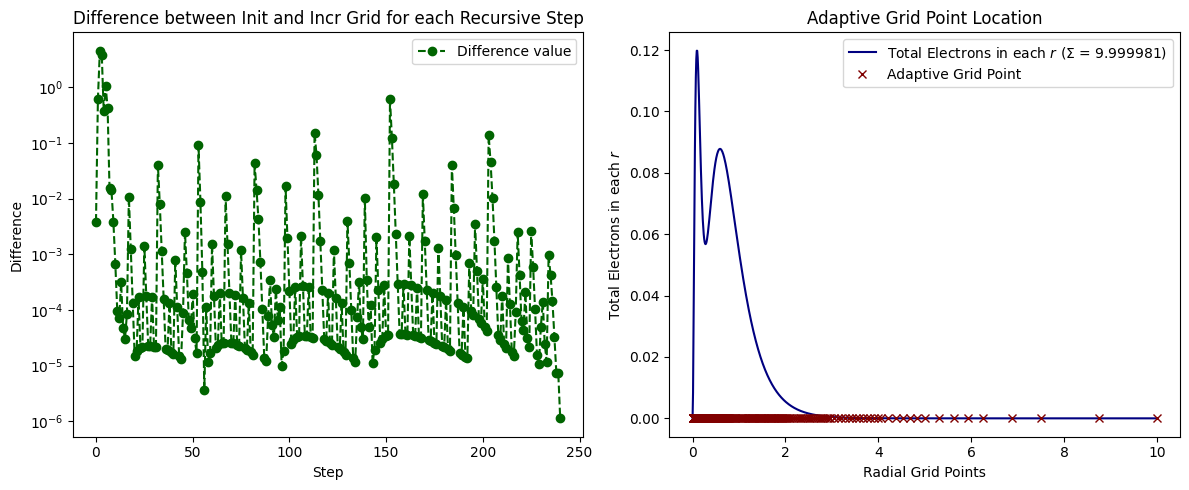

In [23]:
sum_e = np.sum(density_list)
r_values = np.linspace(0, 10, 1000)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First subplot
axes[0].plot(global_diff_list, marker='o', linestyle='--', label='Difference value', color='darkgreen')
axes[0].set_title("Difference between Init and Incr Grid for each Recursive Step")
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Difference")
axes[0].set_yscale('symlog', linthresh=1e-6)
axes[0].legend()

# Second subplot
plt.plot(r_values, density_list, label=f'Total Electrons in each $r$ (Σ = {sum_e:.6f})', color='navy')
axes[1].plot(global_xc_list, np.repeat(0, len(global_xc_list)), 'x', markersize=6, label='Adaptive Grid Point', color='maroon')
axes[1].set_title("Adaptive Grid Point Location")
axes[1].set_xlabel("Radial Grid Points")
axes[1].set_ylabel("Total Electrons in each $r$")
axes[1].legend()
plt.tight_layout()

plt.savefig('adaptive_radial_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()

Reference Neon Plot: https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Book%3A_Quantum_States_of_Atoms_and_Molecules_%28Zielinksi_et_al%29/09%3A_The_Electronic_States_of_the_Multielectron_Atoms/9.09%3A_Chemical_Applications_of_Atomic_Structure_Theory/9.9.9C%3A_9.9.9C%3A_Atomic_Sizes_and_Electron_Density_Distributions


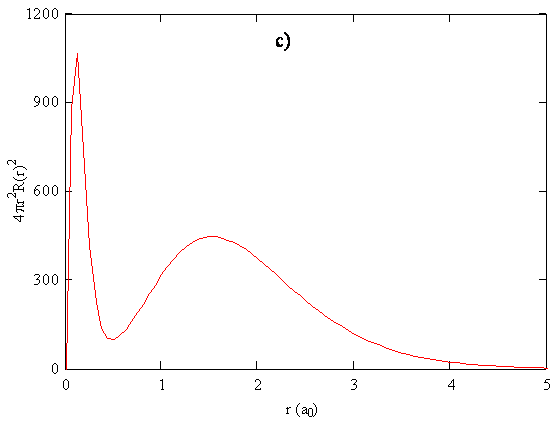
